# Distribution fitting with pytorch 

## Overview 
This is a POC of using pytorch to do distribution fitting. This might be useful because it might give us more control over things like parameter initialization, learning rate, and optimization configuration. Also, it makes it easy to track how estimates change during the optimization process. This can help us identify cases where we're getting stuck in local minima. 

- Use the likelihood function of weibull 2p as the loss function 
- The "model" is really just the shape and scale params. During training, we run N iterations. In each iteration, we use the current estimated params to evaluate the loss, calculate gradient, and take an optimization step. 
- After some experimentation, the following config seems to work well: 
  - Initialize weights/params with `weights = torch.distributions.Uniform(0, 4).sample((2,))`
  - Use optimizer `torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)`
  - Use n=2000 iterations in training loop (similar to epochs in more standard ML problems)


Other things to try: 
- Direct comparison with scipy and reliability fits
- For both LBFGS and Adam, how to deal with the case where param estimate becomes negative? When that happens at a certain optimization step, the loss for that step in nan, and then all further steps fail.
- Check why Adam can't deal estimate large scale values (larger than 1.0). ~Confirm that LBFGS can.~ 
- Confirm that it makes sense that the loss function can become negative. In most of the good fits I see, this is the case. 
- How to deal with the case where some infant mortality "pollutes" an otherwise wearout curve? Should we do 2 fits: one on full data, one on data from in \[median/5 to max\], then compare the shapes? If there's a big change, most likely a superposition? 
- Set up tracking of validation loss + early stopping
- Fit mixtures of Weibulls instead of single weibulls. See function `weibull_mixture_nll` below. We would also have to change the `Model` class to have six weights: `p1, p2, shape1, shape2, scale1, scale2`. However, keep in mind that the goal is not perfect fit. Focus on interpretability and business purpose over perfect fit. 





## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 100
shape = 4
scale = 10

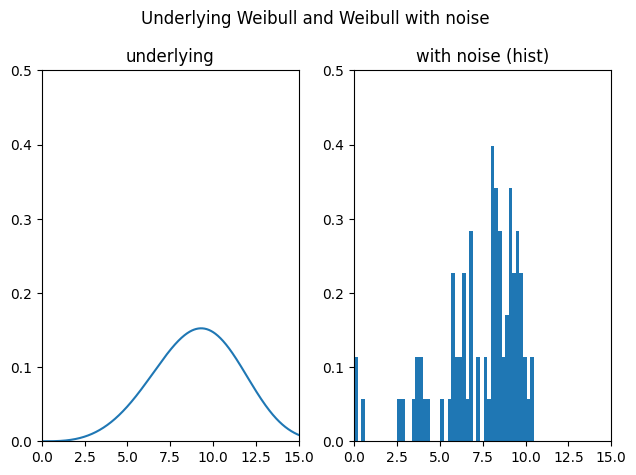

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

truncate = True 
trunc_limit = scale + .5
if truncate: 
    weibull_data = weibull_data[weibull_data < trunc_limit]
    
add_infant_mortality = True 
im_shape = .5
im_scale = scale/2
im_num_points = int(n/10)
if add_infant_mortality: 
    weibull_data = np.concatenate([weibull_data, weibull_min.rvs(c=im_shape, scale=im_scale, size=im_num_points)])

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 25, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=50, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 15)
    ax[idx].set_ylim(0, .5)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

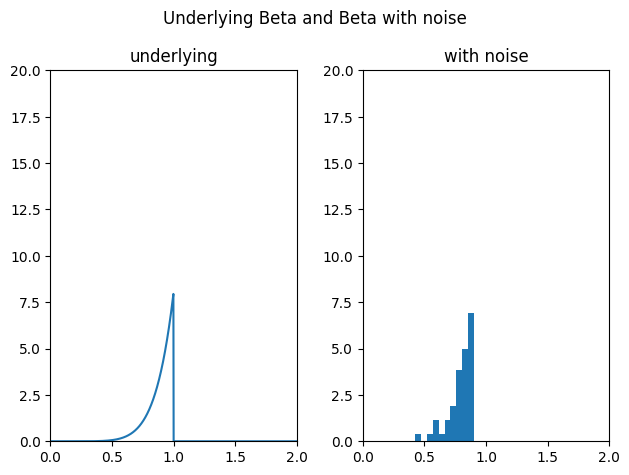

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

truncate = True 
trunc_limit = .9
if truncate: 
    beta_data = beta_data[beta_data < trunc_limit]


#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

# set up tensor for pytorch ops 
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [7]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        if i % 100 == 0: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        
    return losses

In [8]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

In [9]:
def weibull_mixture_nll(data, alphas, betas, pis):
    # todo: verify that this is correct 
    data = data.unsqueeze(1).expand_as(alphas)
    likelihood = pis * torch.exp((torch.log(data) - torch.log(alphas)) * betas - (data / alphas) ** betas)
    log_likelihood = torch.log(likelihood.sum(dim=1)).sum()
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 

iter 0: 3.928645610809326, 3.13840651512146, 726.2466369179982
iter 100: 4.634872913360596, 2.414724349975586, 319.37343426863697
iter 200: 4.981419563293457, 2.064443349838257, 263.47941431795687
iter 300: 5.212462902069092, 1.8765090703964233, 247.39040443240935
iter 400: 5.3929243087768555, 1.7850455045700073, 240.9739617389995
iter 500: 5.549022674560547, 1.753929615020752, 237.38328518530147
iter 600: 5.692843914031982, 1.7603188753128052, 234.65615713494378
iter 700: 5.830101490020752, 1.7896324396133423, 232.2108342750603
iter 800: 5.9633331298828125, 1.8328018188476562, 229.8894815377863
iter 900: 6.093423366546631, 1.8842791318893433, 227.66353780919843
iter 1000: 6.220417022705078, 1.9406429529190063, 225.54107966445426
iter 1100: 6.3439531326293945, 1.9997129440307617, 223.5380580914893
iter 1200: 6.463520526885986, 2.0600249767303467, 221.66920379620768
iter 1300: 6.578586101531982, 2.1205382347106934, 219.9453519655235
iter 1400: 6.688657760620117, 2.1

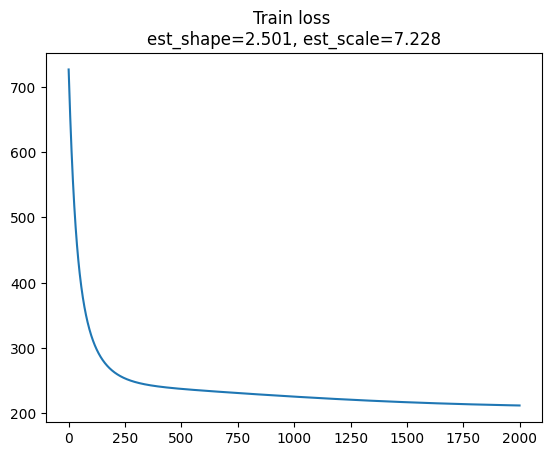

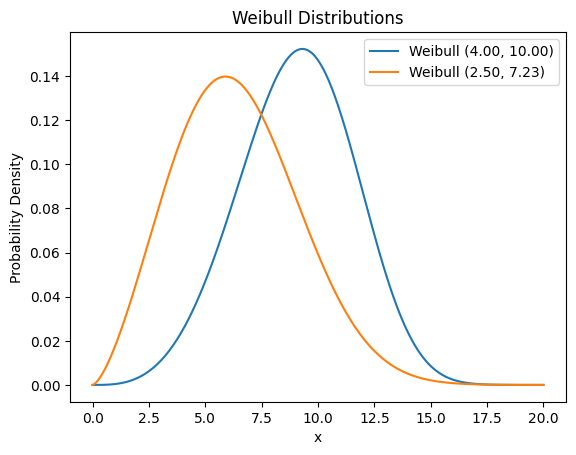

Actual shape=4


In [10]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 

iter 0: 0.14149977266788483, 1.9888839721679688, 1764.559280796264
iter 100: 0.419460266828537, 1.700070858001709, 62.357003562810085
iter 200: 0.49535784125328064, 1.6648969650268555, 37.43653087275323
iter 300: 0.5496737360954285, 1.6796597242355347, 27.497312769507978
iter 400: 0.5927077531814575, 1.7232571840286255, 21.42755935703589
iter 500: 0.6284524202346802, 1.7849503755569458, 16.805978269224322
iter 600: 0.6587871313095093, 1.8582419157028198, 12.909257615279614
iter 700: 0.6847185492515564, 1.9388574361801147, 9.480742729110501
iter 800: 0.7068613767623901, 2.023864507675171, 6.412543465898349
iter 900: 0.7256494760513306, 2.111215591430664, 3.646831006363233
iter 1000: 0.741435706615448, 2.1994762420654297, 1.1428500480195904
iter 1100: 0.7545408010482788, 2.2876570224761963, -1.1339087850785203
iter 1200: 0.7652725577354431, 2.375081777572632, -3.214231538856809
iter 1300: 0.7739318013191223, 2.4613091945648193, -5.125662060410865
iter 1400: 0.7808123

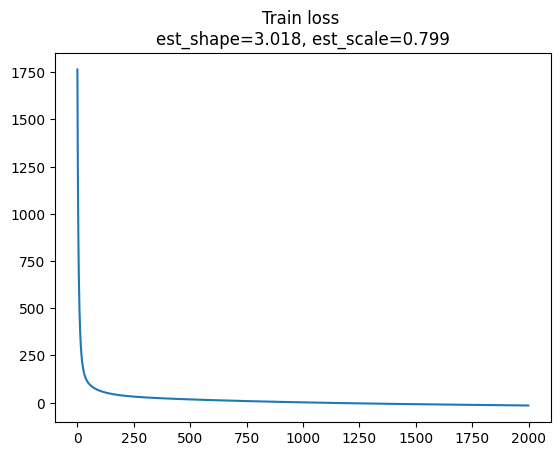

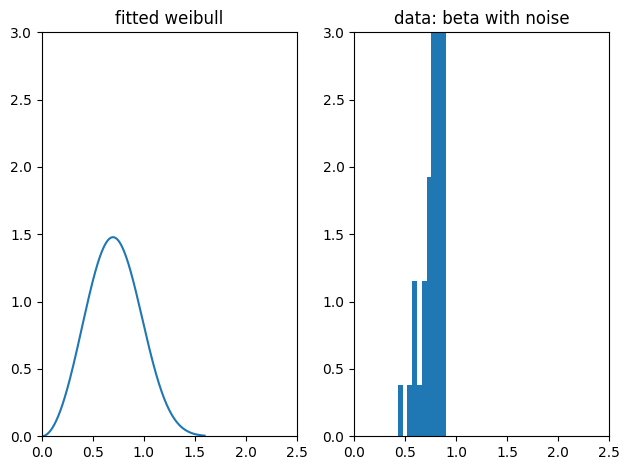

In [11]:
m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS optimizer on Weibull data 

scale, shape, loss 

iter 0: 0.9918727874755859, 2.415894031524658, 12065.249389252735
iter 0: 1.0451127290725708, 2.369133949279785, 9605.488989388887
iter 0: 1.0605193376541138, 2.352813959121704, 8957.632240856106
iter 0: 1.0768219232559204, 2.3323493003845215, 8272.590229968178
iter 0: 1.09195876121521, 2.309781074523926, 7634.339036884709
iter 0: 1.1059370040893555, 2.284917116165161, 7036.464243569628
iter 0: 1.1186567544937134, 2.2577054500579834, 6477.232215626829
iter 0: 1.1300231218338013, 2.228091239929199, 5954.726357261968
iter 0: 1.1399409770965576, 2.196026086807251, 5467.096953021202
iter 0: 1.1483161449432373, 2.161468744277954, 5012.551910873655
iter 0: 1.1550559997558594, 2.1243882179260254, 4589.380208853175
iter 0: 1.160070776939392, 2.084763526916504, 4195.930080842038
iter 0: 1.1632746458053589, 2.0425877571105957, 3830.6323625104224
iter 0: 1.1645877361297607, 1.997869849205017, 3491.990334590597
iter 0: 1.1639376878738403, 1.9506378173828125, 3178.585277076818


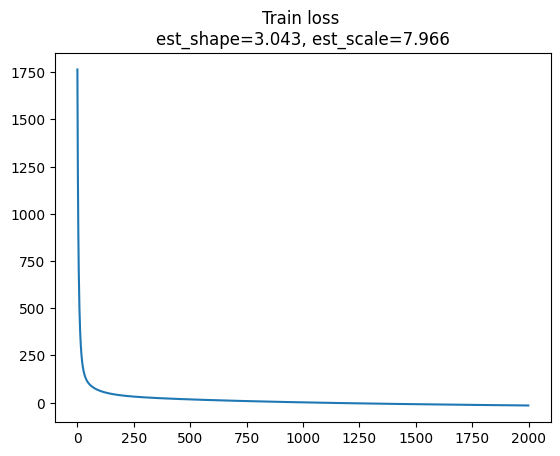

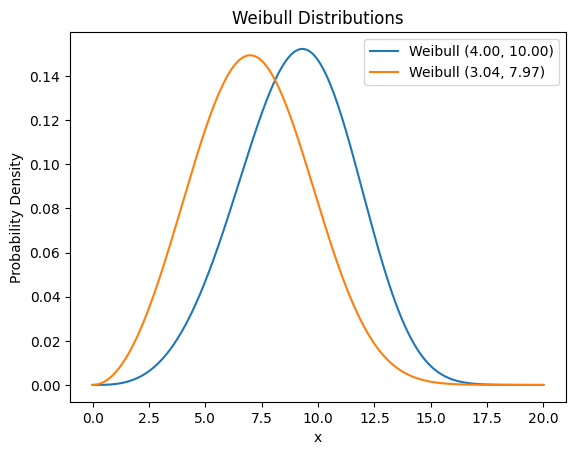

Actual shape=4


In [12]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}'
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

****
# Using LBFGS optimizer on Beta data 

scale, shape, loss 

iter 0: 0.01907038688659668, 0.24105548858642578, 150.29675772179894
iter 0: 0.11268657445907593, 0.2346716821193695, 127.98453352047352
iter 0: 0.1136637032032013, 0.23637957870960236, 127.62674322217393
iter 0: 0.12855607271194458, 0.25942710041999817, 122.92548644825915
iter 0: 0.145737424492836, 0.283590167760849, 118.30784434302007
iter 0: 0.16700658202171326, 0.31141331791877747, 113.32199860323202
iter 0: 0.19274774193763733, 0.3432925343513489, 107.98085405661755
iter 0: 0.2236112654209137, 0.3800293505191803, 102.24392446579695
iter 0: 0.2602301239967346, 0.42253172397613525, 96.08216584977744
iter 0: 0.30306658148765564, 0.4717543423175812, 89.49199264573696
iter 0: 0.3521280884742737, 0.5284870862960815, 82.52296301096669
iter 0: 0.40663930773735046, 0.5929913520812988, 75.30615384733653
iter 0: 0.46482619643211365, 0.6645581722259521, 68.0662385520298
iter 0: 0.5240730047225952, 0.7413185238838196, 61.08868300255703
iter 0: 0.5815765261650085, 0.8206688

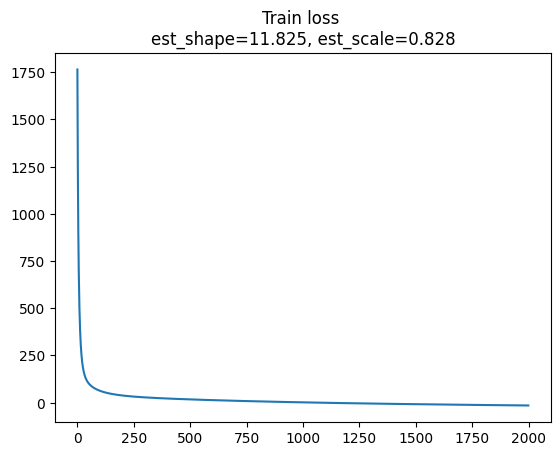

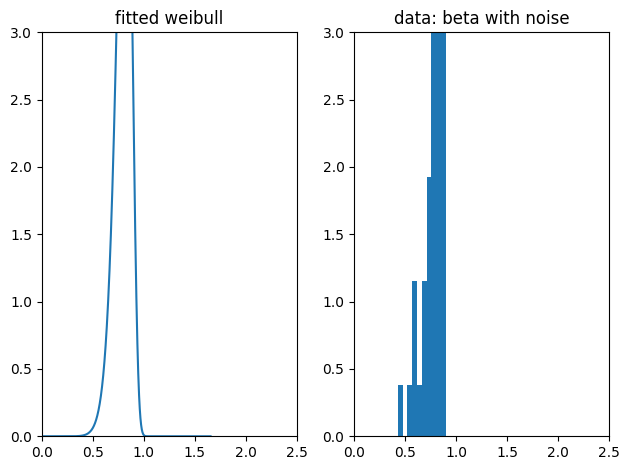

In [13]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
print('scale, shape, loss \n')
num_iterations = 2000
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(beta_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(beta_tensor, lambda_, k)
        loss.backward()
        if i % 100 == 0 or i == num_iterations-1: 
            print(f'iter {i}: {lambda_}, {k}, {loss}')
        return loss

    optimizer.step(closure)

fitted_params = model2.weights
estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

txt = f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}' 
plt.plot(losses)
plt.title(txt)
# plt.ylim(bottom=0)
plt.show()

txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'data: beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()

****
# Random stuff 

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


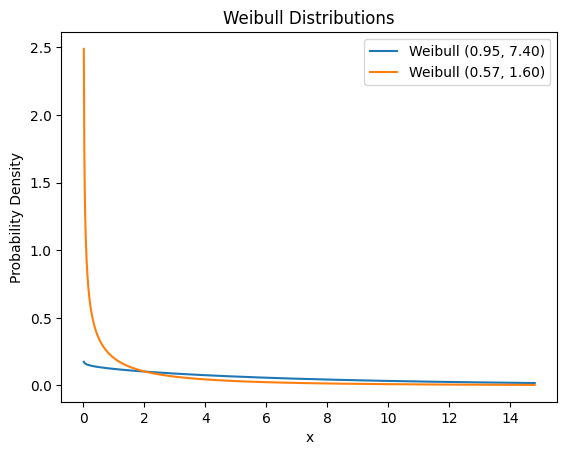

In [14]:
plot_weibull_distributions((.95, 7.4), (.57, 1.6))